In [1]:
import tensorflow as tf
import numpy as np
from tfUtils import *
import matplotlib.pyplot as plt
import innvestigate

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Activation, Dense, Flatten, ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D
from keras.models import Model

In [3]:
def generate_data(m, n_x, seed = 9):
    np.random.seed(seed)
    X = np.random.randn(m, n_x)
    Y = np.zeros((m, 2))
    dist = np.random.randint(low = 0, high = n_x-1, size = m)
    for i in range(m):
        t = np.random.rand();
        if t < 0.5:
            X[i, dist[i]] = -20
            Y[i, 0] = 1
        elif t >= 0.5:
            X[i, dist[i]] = 20
            Y[i, 1] = 1
    return X, Y, dist

In [4]:
def initialize_parameters(shape, name, which):
    if which == "weights":
        return tf.get_variable(name, shape, 
                               initializer = tf.contrib.layers.xavier_initializer())
    elif which == "bias":
        return tf.get_variable(name, shape, 
                              initializer = tf.zeros_initializer())
    return

In [5]:
def create_placeholders(n_h, n_w, n_c, n_y):
    X = tf.placeholder(tf.float32, [None, n_h, n_w, n_c])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [6]:
def flatten(layer):
    size = layer.get_shape()
    num_features = size[1] * size[2] * size[3]
    flattened_layer = tf.reshape(layer, [-1, num_features])
    return flattened_layer, num_features

In [7]:
def fully_connected(layer, input_features, output_features, activation, indicator):
    weights = initialize_parameters([input_features, output_features], "W" + str(indicator), "weights")
    bias = initialize_parameters([1, output_features], "b" + str(indicator), "bias")
    Z = tf.matmul(layer, weights) + bias
    if activation == "relu":
        return tf.nn.relu(Z), weights, bias
    elif activation == "sigmoid":
        return tf.nn.sigmoid(Z), weights, bias
    elif activation == "tanh":
        return tf.nn.tanh(Z), weights, bias
    elif activation == "linear":
        return Z, weights, bias

In [8]:
def conv_2D(layer, filter_size, output_channels, stride, padding, activation, use_maxpool, indicator):
    input_channels = layer.get_shape()[3]
    weights = initialize_parameters([filter_size, filter_size, input_channels, output_channels], "W" + str(indicator), 
                                   "weights")
    bias = initialize_parameters([output_channels], "b" + str(indicator), "bias")
    Z = tf.nn.conv2d(layer, weights, strides = [1, stride, stride, 1], padding = padding) + bias
    if activation == "relu":
        A = tf.nn.relu(Z)
    elif activation == "sigmoid":
        A = tf.nn.sigmoid(Z)
    elif activation == "tanh":
        A = tf.nn.tanh(Z)
    elif activation == "linear":
        A = Z
    if use_maxpool:
        return tf.nn.max_pool(A, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID'), weights, bias
    else:
        return A, weights, bias

In [9]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    return cost

In [10]:
X_train, Y_train, dist = generate_data(50000, 144)
X_train = X_train.reshape(-1, 12, 12, 1)

In [11]:
def model(X_train, Y_train, layers, filter_size, stride, padding, activation,
          epochs, batch_size, starting_rate, decay, use_maxpool):
    tf.reset_default_graph()
    input_shape = X_train.shape
    output_shape = Y_train.shape
    X, Y = create_placeholders(input_shape[1], input_shape[2], input_shape[3], output_shape[1])
    parameters = {}
    A = X
    already_flat = 0
    for i in range(1, len(layers) + 1):
        if layers[i - 1][0] == 'conv_2D':
            A, parameters['W' + str(i)], parameters['b' + str(i)] = conv_2D(
                A, filter_size, layers[i - 1][1], stride, padding, activation[i - 1], use_maxpool, indicator = i)
        elif layers[i - 1][0] == 'fc':
            if already_flat == 0:
                A, input_layers = flatten(A)
                already_flat = 1
            else: input_layers = A.get_shape()[1]
            A, parameters['W' + str(i)], parameters['b' + str(i)] = fully_connected(
                A, input_layers, layers[i - 1][1], activation[i - 1], indicator = i)
    cost = compute_cost(A, Y)
    hard_A = tf.argmax(tf.nn.softmax(A, axis = 1), axis = 1)
    acc = tf.reduce_mean(tf.cast(tf.equal(hard_A, tf.argmax(Y, axis = 1)), tf.float32))
    global_steps = tf.Variable(0, trainable = False)
    learning_rate = tf.train.exponential_decay(starting_rate, global_steps, 5000, decay, staircase = True)
    train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step = global_steps)
    init = tf.global_variables_initializer()
    cost_list = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            minibatches = random_minibatches(X_train, Y_train, batch_size, seed = epoch)
            epoch_cost = 0
            for minibatch in minibatches:
                sess.run(train, feed_dict = {X : minibatch[0], Y : minibatch[1]})
                epoch_cost += sess.run(cost, feed_dict = {X : minibatch[0], Y : minibatch[1]}) / len(minibatches)
            cost_list.append(epoch_cost)        
            if epoch % 5 == 0:
                print(epoch_cost)
        parameter_names = []
        parameter_list = []
        for i in range(1, len(parameters) // 2 + 1):
            parameter_names.append("W" + str(i))
            parameter_names.append("b" + str(i))
        for j in range(len(parameter_names)):
            parameter_list.append(sess.run(parameters[parameter_names[j]]))
        print("accuracy", sess.run(acc, feed_dict = {X : X_train, Y : Y_train}))
    sess.close()
    plt.plot(np.array(cost_list), '-b')
    plt.show()
    return parameter_list

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

0.21690783220190146
0.20347899054692517
0.18711732002720005
0.15125086967864906
0.10525656055113226
0.06576421117629846
0.035880597501949586
0.01797909735370816
0.008452377720021529
0.0034951671740942923
0.0012529229224549348
0.0004782035565193866
0.00022067330714729103
0.00012835101911478505
0.00010342912184166978
2.305427938439161e-05
1.8759799807240752e-05
8.842251181698078e-05
5.2304638365312996e-06
1.6136047827830797e-06
accuracy 1.0


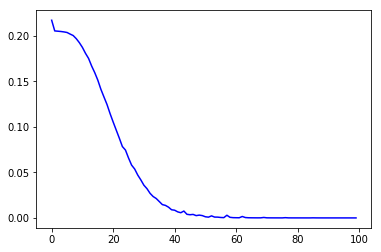

In [12]:
parameter_list_relu = model(X_train, Y_train, layers = [("conv_2D", 32), ("conv_2D", 64), ("fc", 512), ("fc", 1024), ("fc", 2)], 
                           filter_size = 3, stride = 1, padding = 'VALID', 
                            activation = ["relu", "relu", "relu", "relu", "linear"], epochs = 100, batch_size = 32, 
                            starting_rate = 3e-4, decay = .9, use_maxpool = True)

0.26448994784145813
0.1787585659358968
0.11841098095009714
0.07109967764433556
0.030252719758138424
0.010533747111144324
0.004241097223115973
0.0020058648966486776
0.0013168170150322457
0.0004063485546848717
0.0003247800786893575
6.0629036704578794e-05
accuracy 0.99998


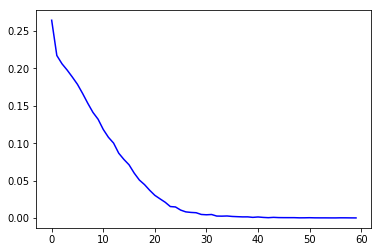

In [13]:
parameter_list_tanh = model(X_train, Y_train, layers = [("conv_2D", 32), ("conv_2D", 64), ("fc", 512), ("fc", 1024), ("fc", 2)], 
                           filter_size = 3, stride = 1, padding = 'VALID', 
                            activation = ["tanh", "tanh", "tanh", "tanh", "linear"], epochs = 60, batch_size = 32, 
                            starting_rate = 5e-4, decay = .85, use_maxpool = True)

0.5958482267332073
0.2437866238278157
0.2341268503507973
0.22734147458530932
0.22457263695389124
0.2217792211934924
0.21991199024647456
0.21850899368062626
0.21775090874969932
0.21727986561730508
0.21665336177773817
0.21630122474282965
0.21614032585620896
0.21582289424329956
0.2157256554253404
0.21566568401612388
0.2155342914485934
0.21556660822719367
0.21549099685788198
0.21541835538521395
accuracy 0.86026


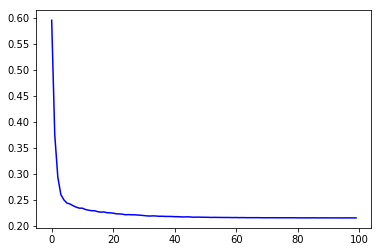

In [14]:
parameter_list_sigmoid = model(X_train, Y_train, layers = [("conv_2D", 32), ("conv_2D", 64), ("fc", 512), ("fc", 1024), ("fc", 2)], 
                           filter_size = 3, stride = 1, padding = 'VALID', 
                            activation = ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "linear"], epochs = 100, batch_size = 16, 
                            starting_rate = 1e-4, decay = .9, use_maxpool = True)

In [16]:
def create_model(input_shape, activations, use_soft):
    X_input = Input(input_shape);
    X = Conv2D(32, (3,3), strides = (1,1), padding = "valid", name = "Z_1")(X_input);
    X = Activation(activations[0])(X);
    X = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "valid", name = "max_pool_1")(X);
    X = Conv2D(64, (3,3), strides = (1,1), padding = "valid", name = "Z_2")(X);
    X = Activation(activations[1])(X);
    X = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "valid", name = "max_pool_2")(X);
    X = Flatten()(X);
    X = Dense(512, activation = activations[2], name = "A_3")(X)
    X = Dense(1024, activation = activations[3], name = "A_4")(X)
    if use_soft:
        X = Dense(2, activation = "softmax", name = "A_5")(X)
    else:
        X = Dense(2, activation = "linear", name = "Z_5")(X)
    model = Model(inputs = X_input, outputs = X)
    return model

In [17]:
np.save('Model Weights and relevant parameters/CNNs/relu_model_weights.npy', parameter_list_relu)
np.save('Model Weights and relevant parameters/CNNs/sigmoid_model_weights.npy', parameter_list_sigmoid)
np.save('Model Weights and relevant parameters/CNNs/tanh_model_weights.npy', parameter_list_tanh)

In [ ]:
parameter_list_relu = np.load('Model Weights and relevant parameters/CNNs/relu_model_weights.npy')
parameter_list_sigmoid = np.load('Model Weights and relevant parameters/CNNs/sigmoid_model_weights.npy')
parameter_list_tanh = np.load('Model Weights and relevant parameters/CNNs/tanh_model_weights.npy')

In [18]:
modelp_relu = create_model(X_train.shape[1:], ["relu", "relu", "relu", "relu"], True)
model_relu = create_model(X_train.shape[1:], ["relu", "relu", "relu", "relu"], False)
modelp_tanh = create_model(X_train.shape[1:], ["tanh", "tanh", "tanh", "tanh"], True)
model_tanh = create_model(X_train.shape[1:], ["tanh", "tanh", "tanh", "tanh"], False)
modelp_sigmoid = create_model(X_train.shape[1:], ["sigmoid", "sigmoid", "sigmoid", "sigmoid"], True)
model_sigmoid = create_model(X_train.shape[1:], ["sigmoid", "sigmoid", "sigmoid", "sigmoid"], False)

In [19]:
modelp_relu.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
modelp_tanh.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
modelp_sigmoid.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
for i in range(len(parameter_list_relu)):
    if i % 2 == 1:
        parameter_list_relu[i] = parameter_list_relu[i].reshape(-1)
        parameter_list_tanh[i] = parameter_list_tanh[i].reshape(-1)
        parameter_list_sigmoid[i] = parameter_list_sigmoid[i].reshape(-1)

In [21]:
modelp_relu.set_weights(parameter_list_relu)
model_relu.set_weights(parameter_list_relu)
modelp_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelp_relu.evaluate(x = X_train, y = Y_train)

50000/50000 [==============================] - 2s 34us/step


[7.095672583182022e-07, 1.0]

In [22]:
modelp_tanh.set_weights(parameter_list_tanh)
model_tanh.set_weights(parameter_list_tanh)
modelp_tanh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelp_tanh.evaluate(x = X_train, y = Y_train)

50000/50000 [==============================] - 2s 33us/step


[8.60691002108615e-05, 0.99998]

In [23]:
modelp_sigmoid.set_weights(parameter_list_sigmoid)
model_sigmoid.set_weights(parameter_list_sigmoid)
modelp_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelp_sigmoid.evaluate(x = X_train, y = Y_train)

50000/50000 [==============================] - 2s 35us/step


[0.2154042530965805, 0.86026]

In [24]:
analyzer_relu = innvestigate.create_analyzer("lrp.alpha_2_beta_1_IB", model_relu)
analyzer_sigmoid = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model_sigmoid)
analyzer_tanh = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model_tanh)

In [43]:
analysis_relu = analyzer_relu.analyze(X_train[:30000, :])
analysis_sigmoid = analyzer_sigmoid.analyze(X_train[:30000, :])
analysis_tanh = analyzer_tanh.analyze(X_train[:30000, :])

In [44]:
rel_me = np.zeros((30000, 144))
for i in range(30000):
    rel_me[i, dist[i]] = 1

In [45]:
rel_me = np.reshape(rel_me, (-1, 12, 12)) 

/home/archie/miniconda3/envs/pavan/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


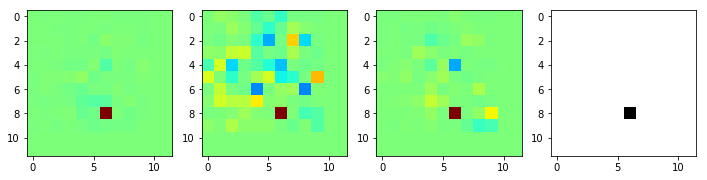

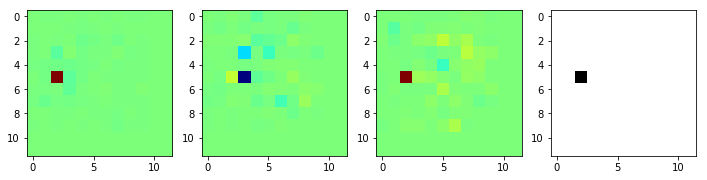

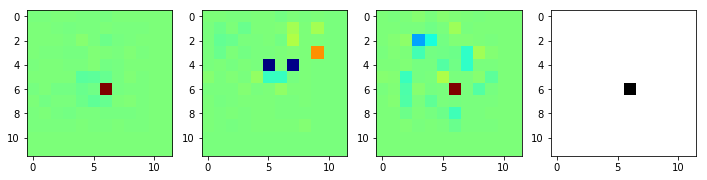

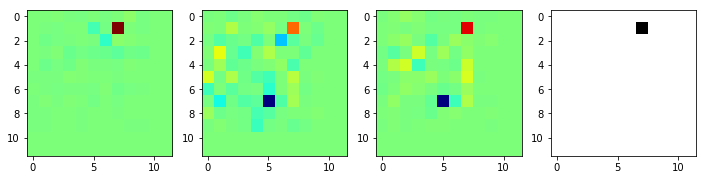

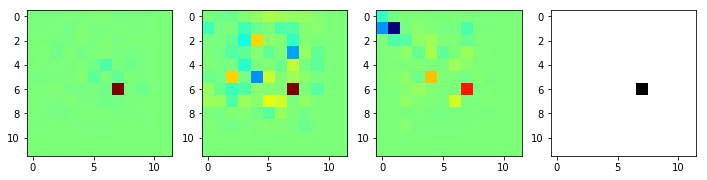

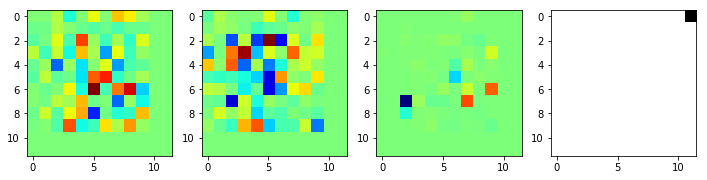

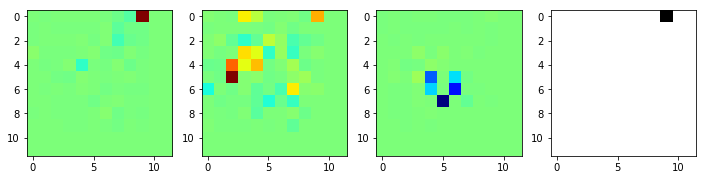

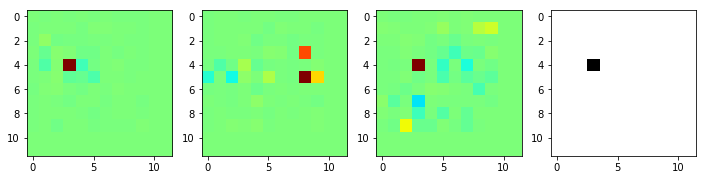

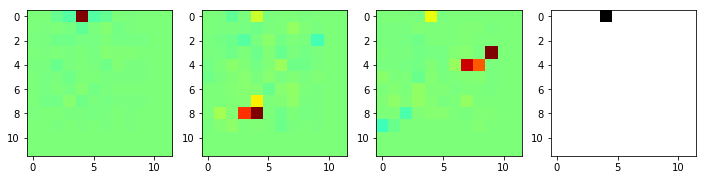

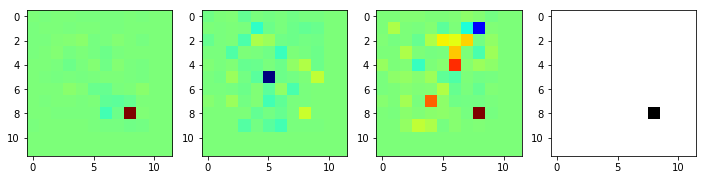

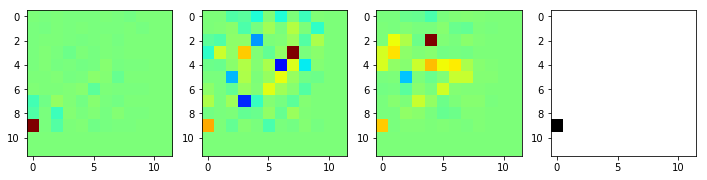

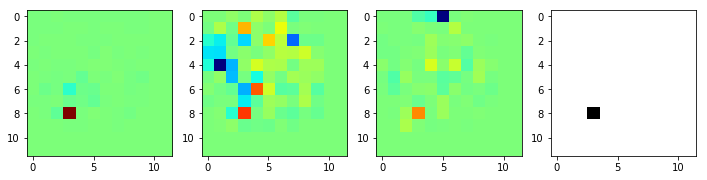

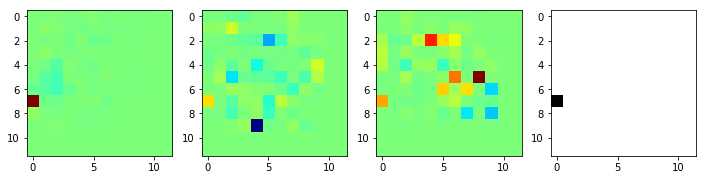

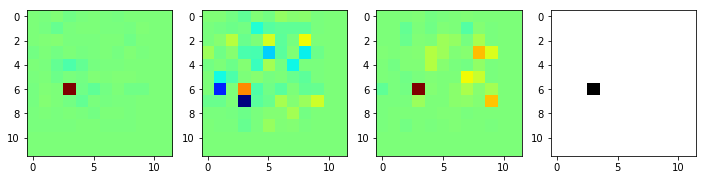

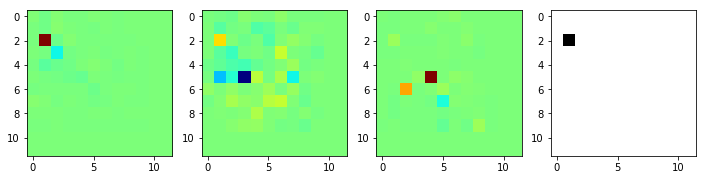

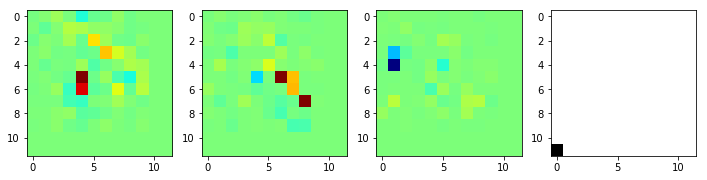

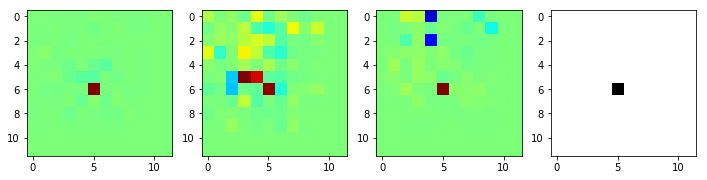

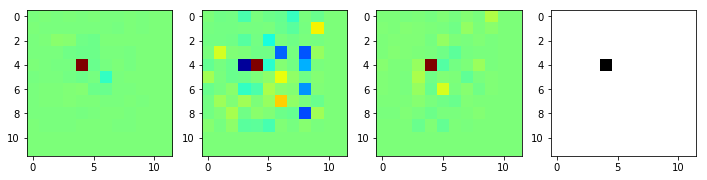

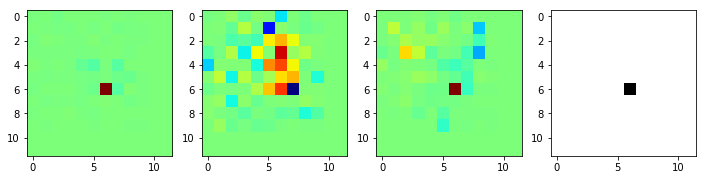

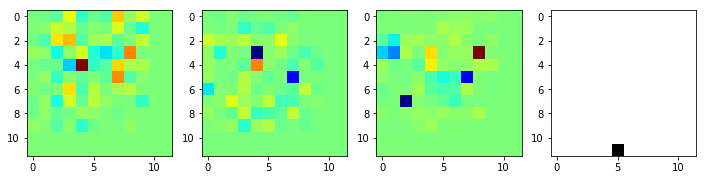

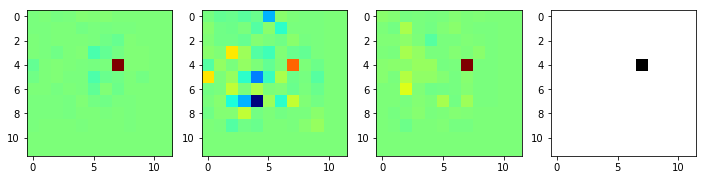

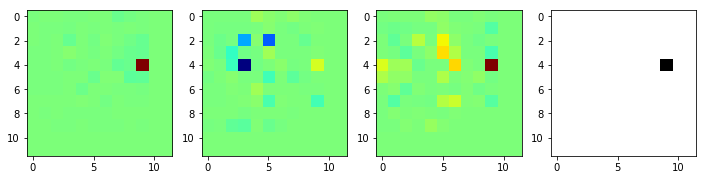

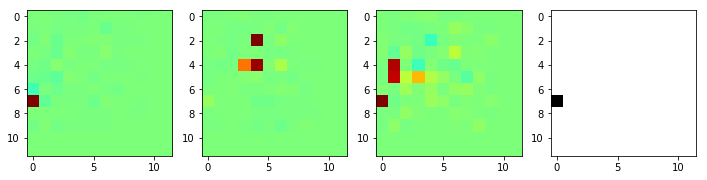

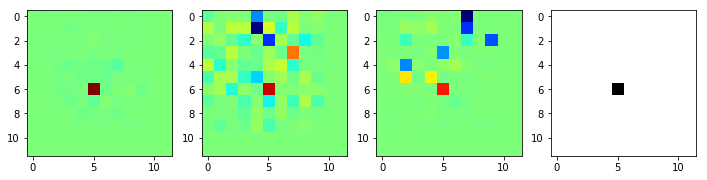

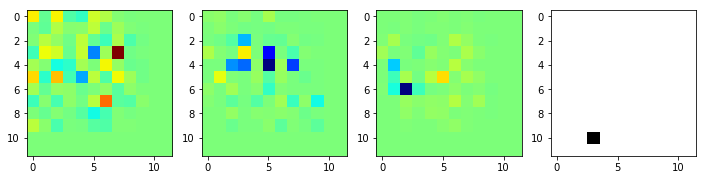

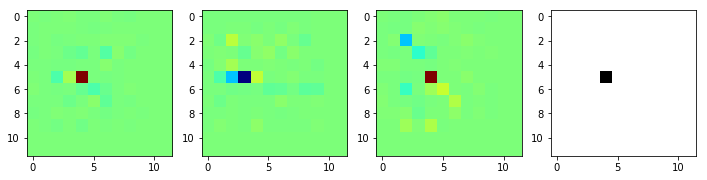

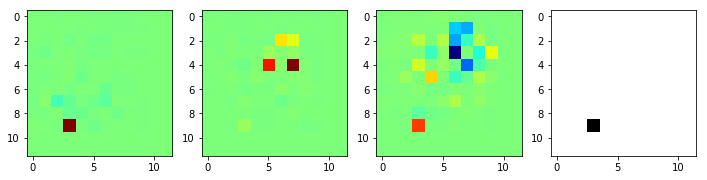

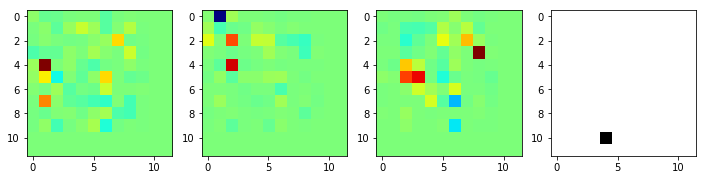

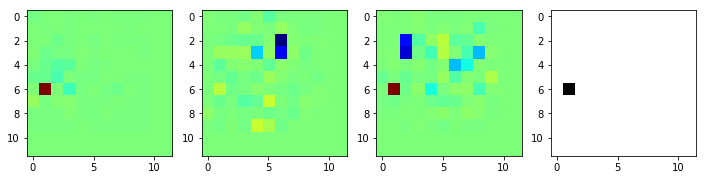

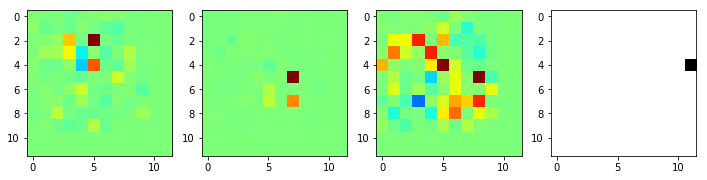

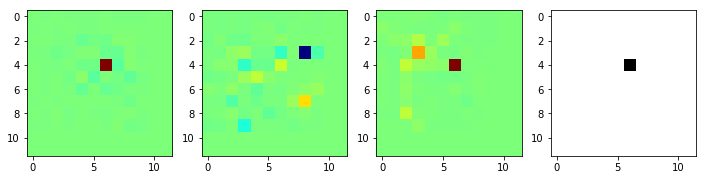

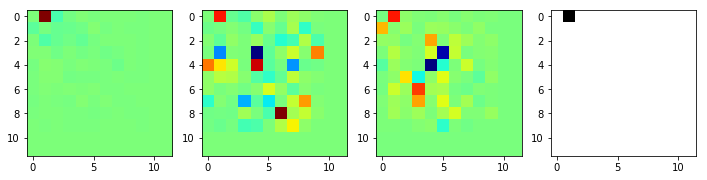

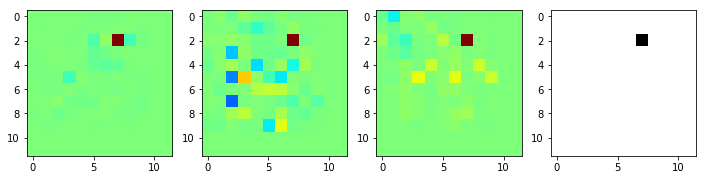

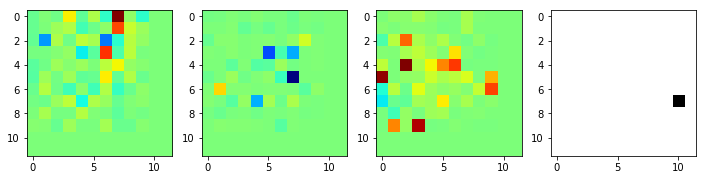

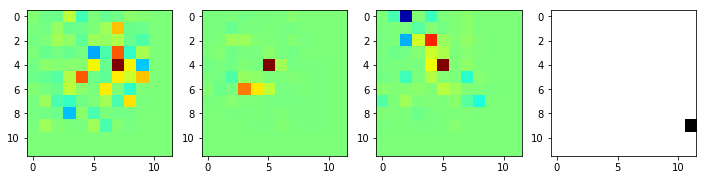

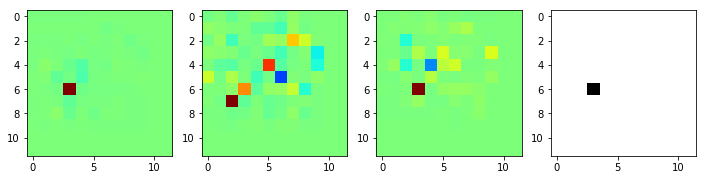

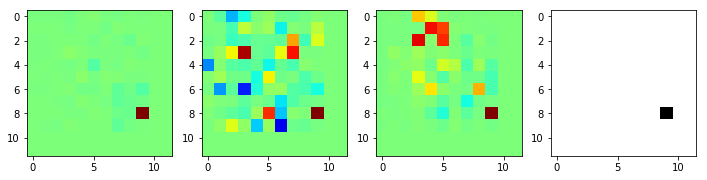

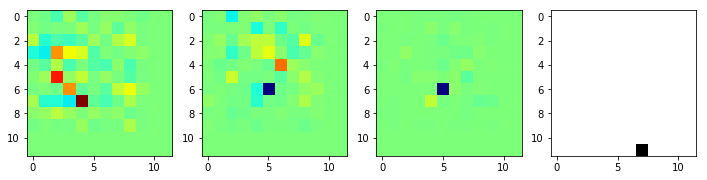

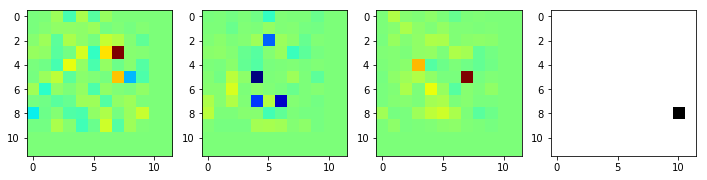

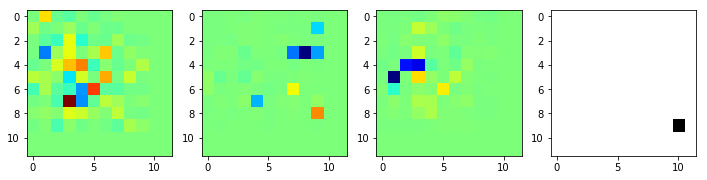

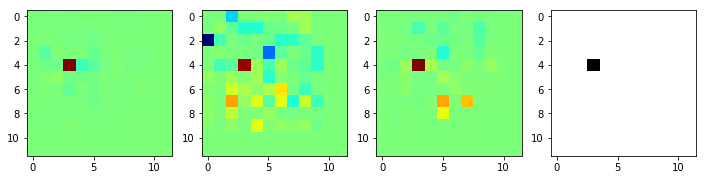

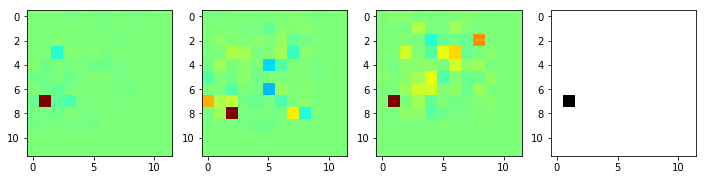

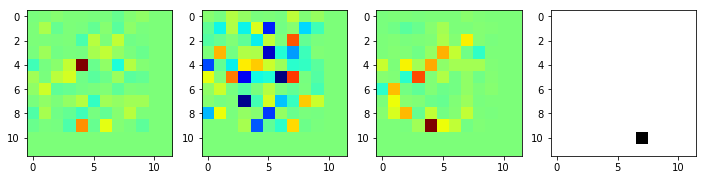

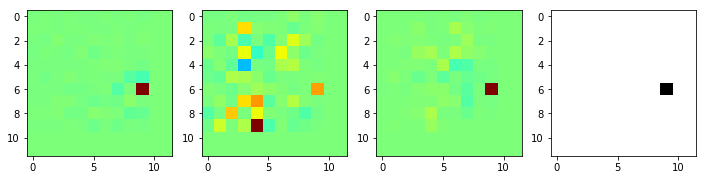

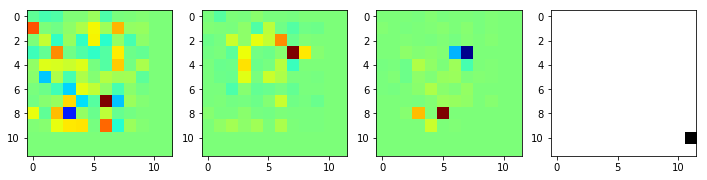

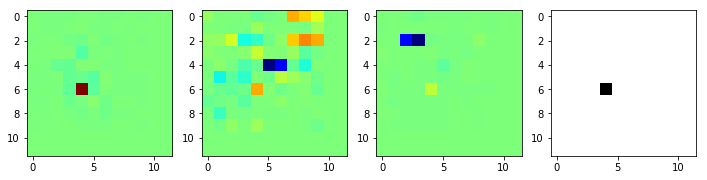

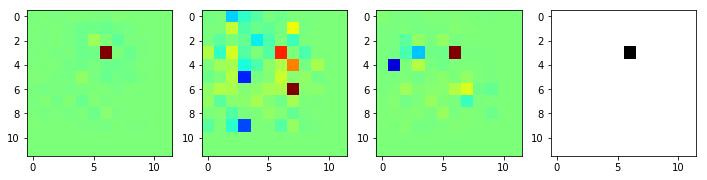

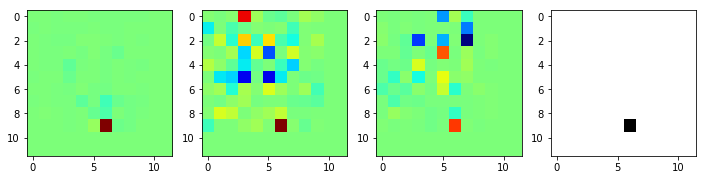

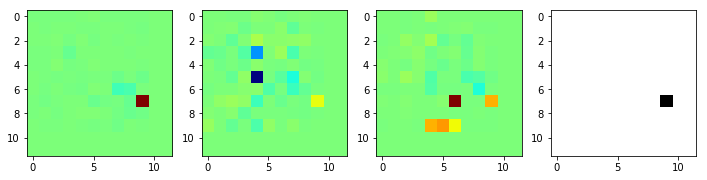

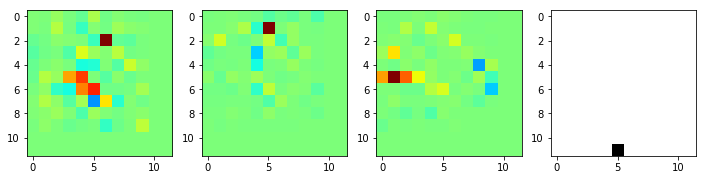

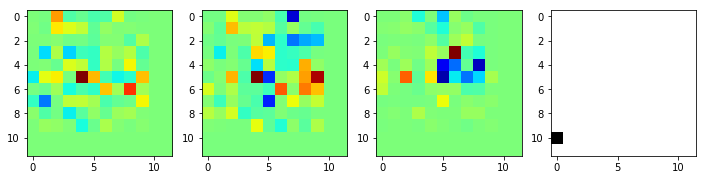

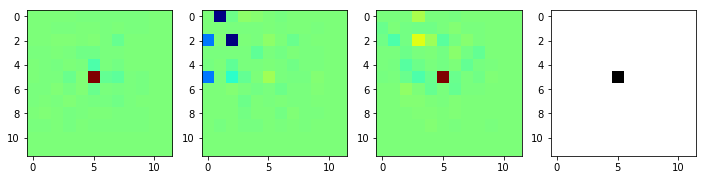

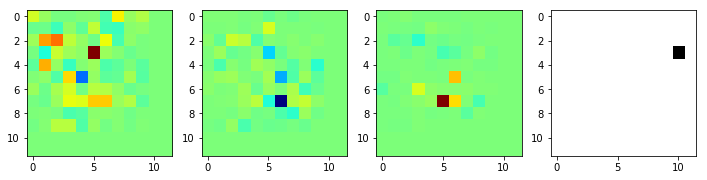

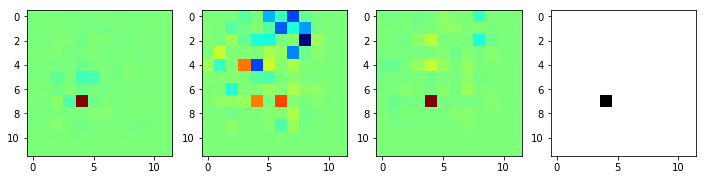

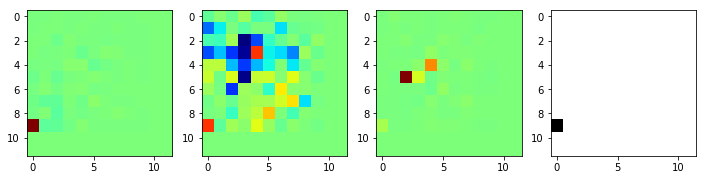

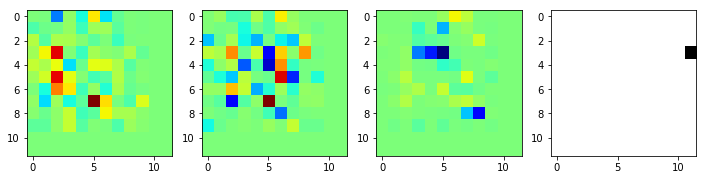

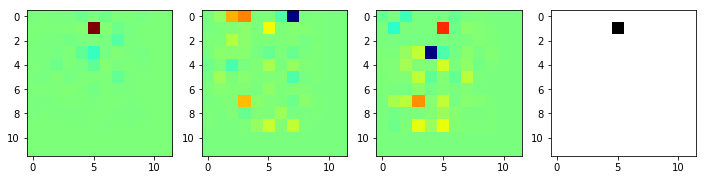

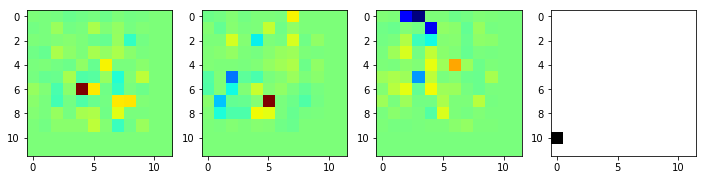

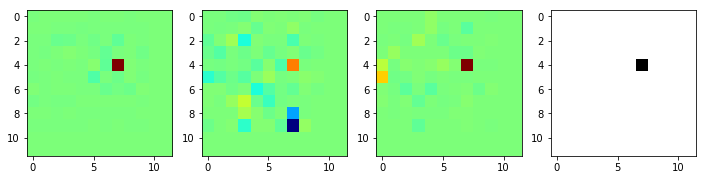

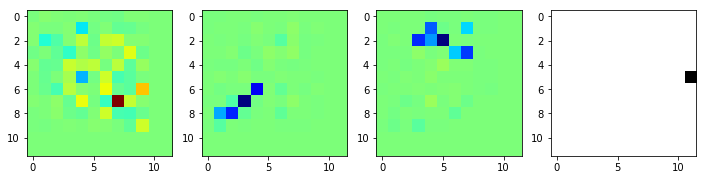

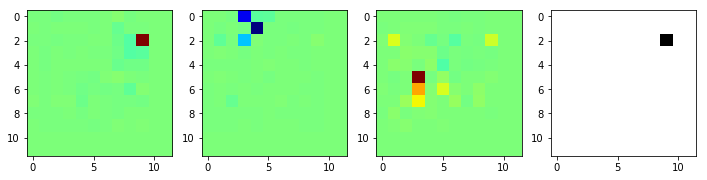

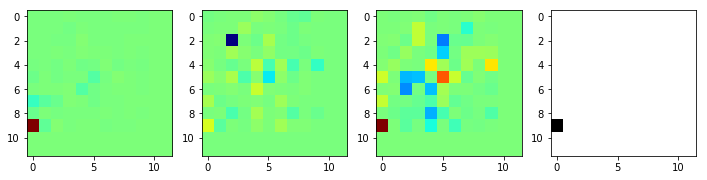

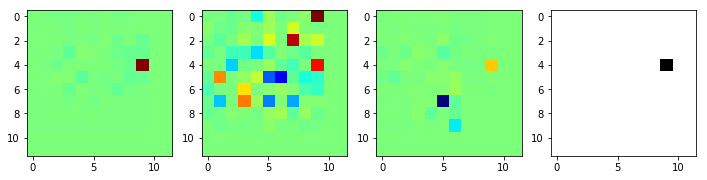

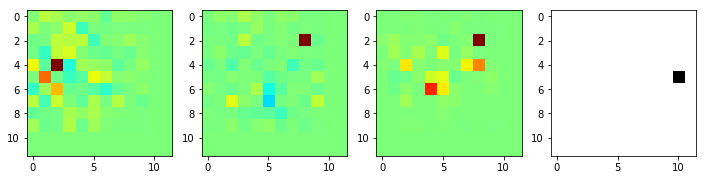

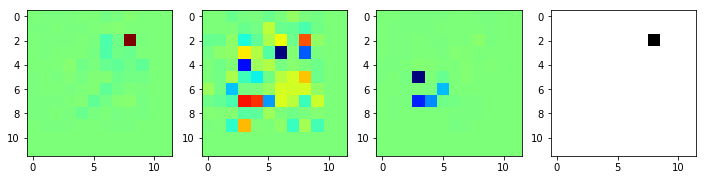

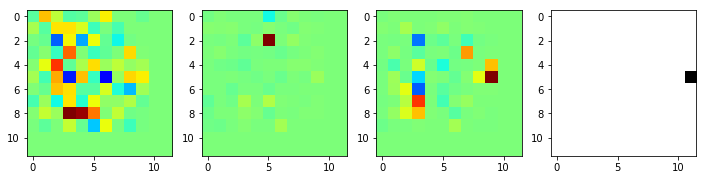

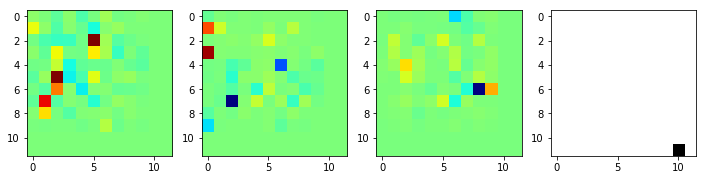

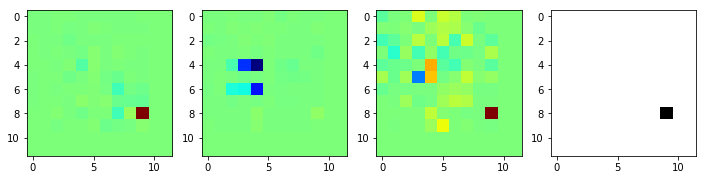

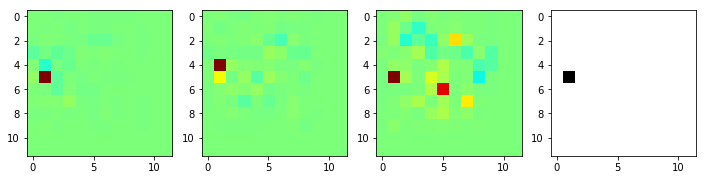

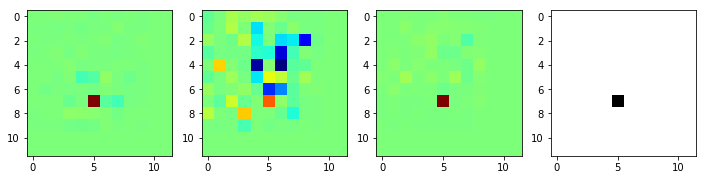

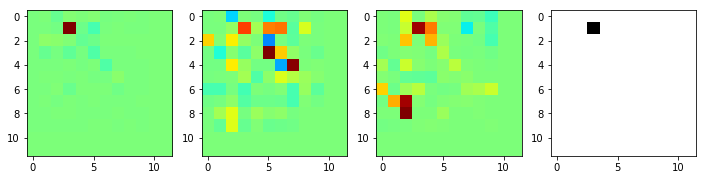

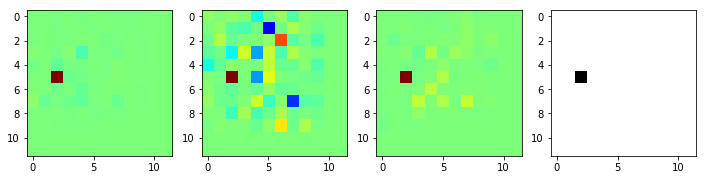

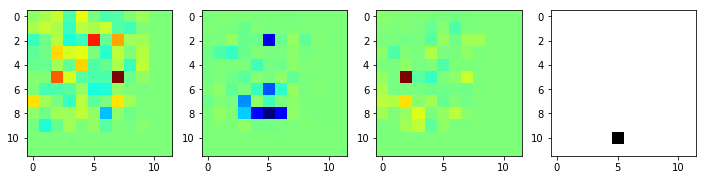

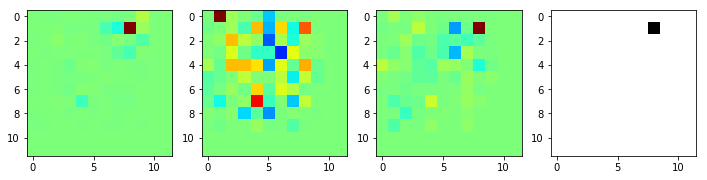

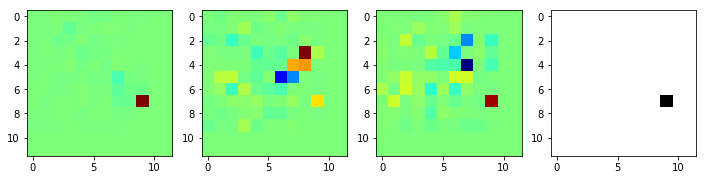

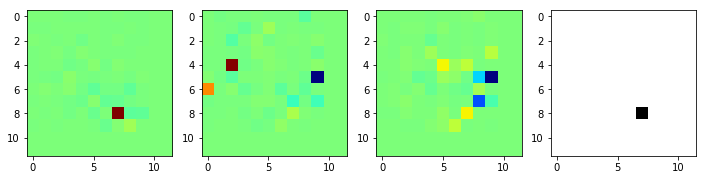

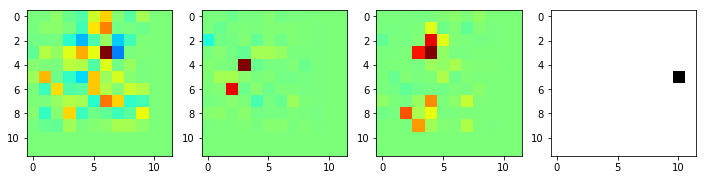

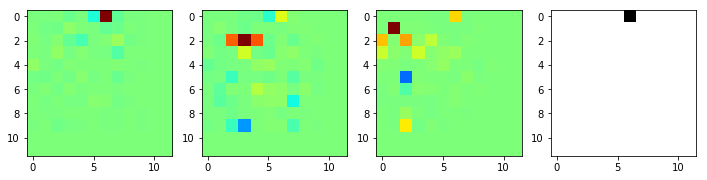

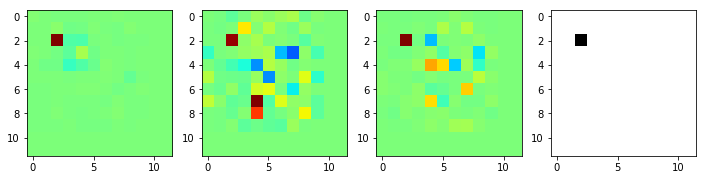

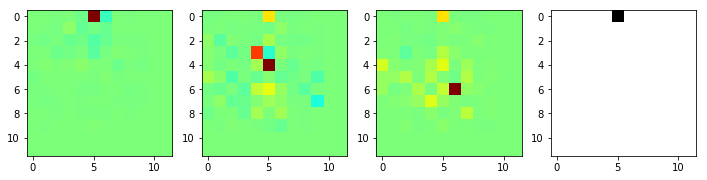

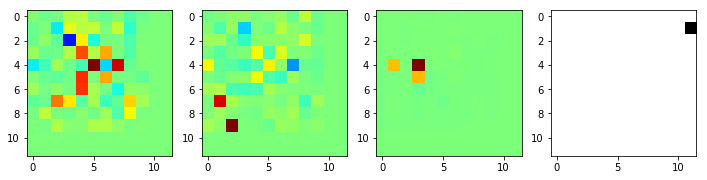

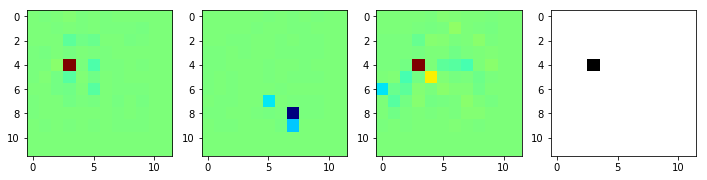

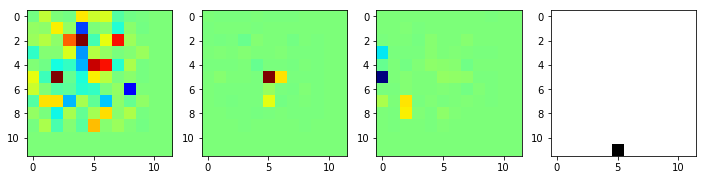

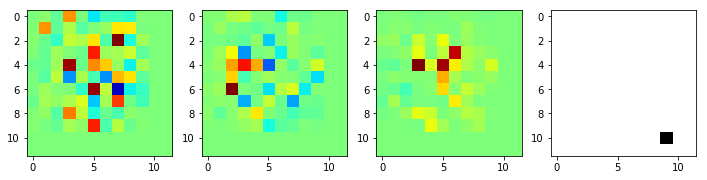

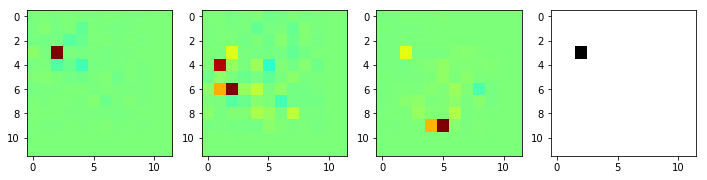

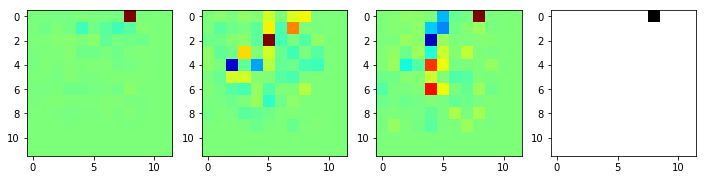

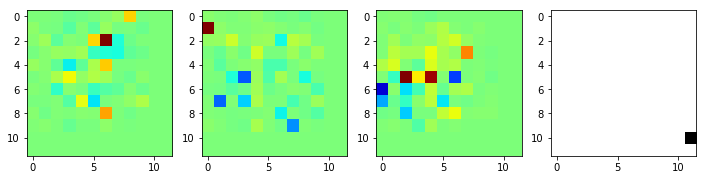

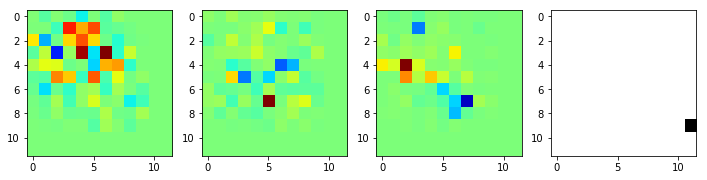

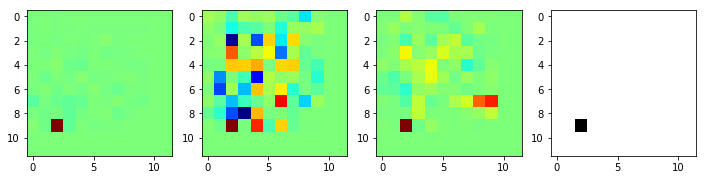

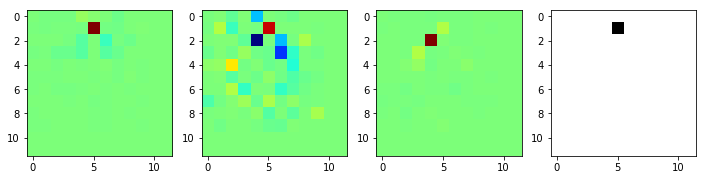

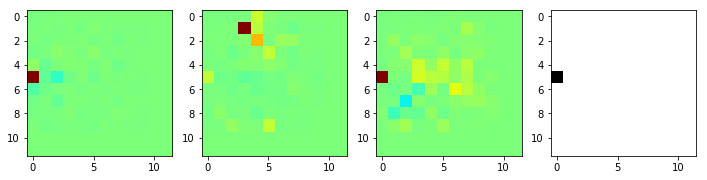

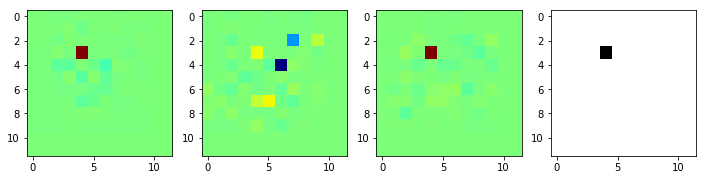

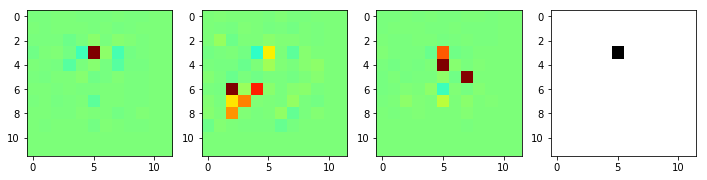

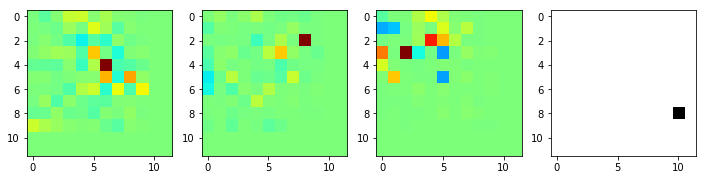

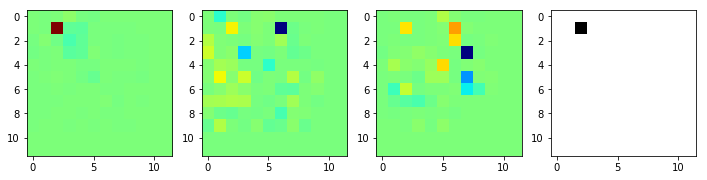

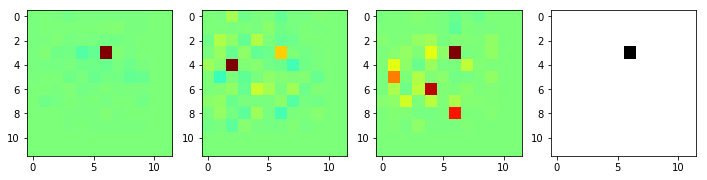

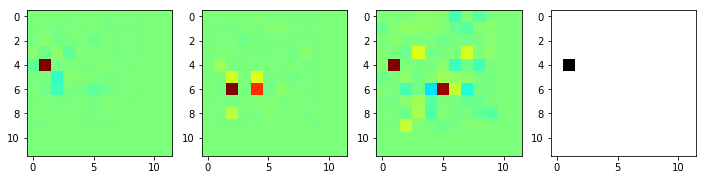

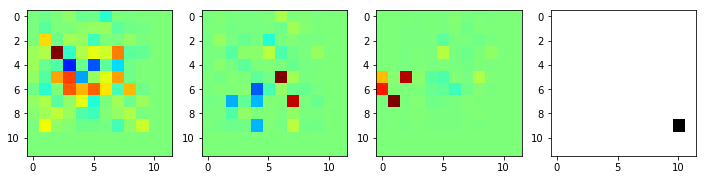

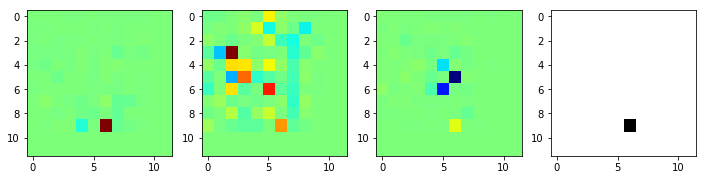

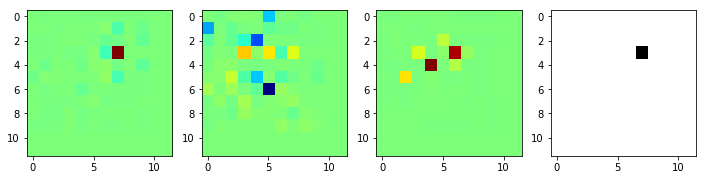

In [49]:
plt.close()
for i in range(100):
    f, axarr = plt.subplots(1, 4, figsize=(12, 12))
    
    m_relu = np.max(np.abs(analysis_relu[i,:,:,0]))
    a_relu = ((analysis_relu[i,:,:,0] / m_relu) + 1) / 2
    
    m_sigmoid = np.max(np.abs(analysis_sigmoid[i,:,:,0]))
    a_sigmoid = ((analysis_sigmoid[i,:,:,0] / m_sigmoid) + 1) / 2
    
    m_tanh = np.max(np.abs(analysis_tanh[i,:,:,0]))
    a_tanh = ((analysis_tanh[i,:,:,0] / m_tanh) + 1) / 2
    
    fig = axarr[0].imshow(a_relu, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[1].imshow(a_sigmoid, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[2].imshow(a_tanh, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[3].imshow(rel_me[i,:,:], cmap = "binary")
plt.show()

In [50]:
counter_relu_pos = 0
counter_relu_min = 0
counter_sigmoid_pos = 0
counter_sigmoid_min = 0
counter_tanh_pos = 0
counter_tanh_min = 0
for i in range(30000):
    a = np.argmax(rel_me[i,:,:])
    counter_relu_pos += (np.argmax(analysis_relu[i,:,:,0]) == a)
    counter_relu_min += (np.argmax(-analysis_relu[i,:,:,0]) == a)
    counter_sigmoid_pos += (np.argmax(analysis_sigmoid[i,:,:,0]) == a)
    counter_sigmoid_min += (np.argmax(-analysis_sigmoid[i,:,:,0]) == a)
    counter_tanh_pos += (np.argmax(analysis_tanh[i,:,:,0]) == a)
    counter_tanh_min += (np.argmax(-analysis_tanh[i,:,:,0]) == a)

In [51]:
print(counter_relu_pos)
print(counter_relu_min)
print(counter_sigmoid_pos)
print(counter_sigmoid_min)
print(counter_tanh_pos)
print(counter_tanh_min)

21080
0
9171
14
14000
4
